In [17]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle
import cv2
from IPython.display import Image, display
torch.set_printoptions(linewidth=120)
from utils import detect_corners, rotmat, marker_proj, find_parameter, mean_loss, quat2rotvec, build_proj_matrix, sim_data


# Simulated Data and ground truth parameter

## Sanity check - loss with ground truth parameter

In [18]:
K = build_proj_matrix(fx=613.9306030273438,  fy=614.3072713216146, ppx=322.1438802083333, ppy=241.59906514485678)
obs_data_std, gt_param = sim_data(n=100, K=K, noise_std=1.0)
print('avg_reproj_px_err', mean_loss(obs_data_std, gt_param, K).item())


avg_reproj_px_err 1.2784875013461754


## Find Optimal Parameter (initialize with zero params)

In [19]:
param=torch.zeros(9, dtype=torch.float64, requires_grad=True)
L = lambda p: mean_loss(obs_data_std, p, K)
print('init param  loss (px err)', L(param).item())
param_star=find_parameter(param, obs_data_std, K)

print('found param loss (px err)', L(param_star).item())
print('truth param loss (px err)', L(gt_param).item())

init param  loss (px err) 926.3490198131373
found param loss (px err) 1.2327859200811764
truth param loss (px err) 1.2784875013461754


## Compare Result

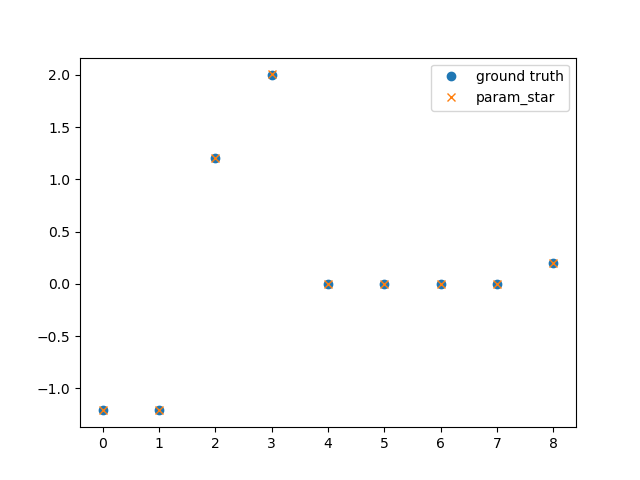

In [20]:
%matplotlib widget
plt.plot(gt_param,'o')
plt.plot(param_star,'x')
plt.legend(['ground truth', 'param_star'])

# Realworld Data Experiment

## Data Inspection

pos_ee_base tensor([ 0.3124, -0.2017,  0.2122])
ori_ee_base tensor([ 0.8507, -0.5183, -0.0854, -0.0171])
intrinsics[0] {'coeffs': [0.0, 0.0, 0.0, 0.0, 0.0], 'fx': 601.3736572265625, 'fy': 600.106201171875, 'height': 480, 'model': <distortion.inverse_brown_conrady: 2>, 'ppx': 321.1289978027344, 'ppy': 234.91824340820312, 'width': 640}


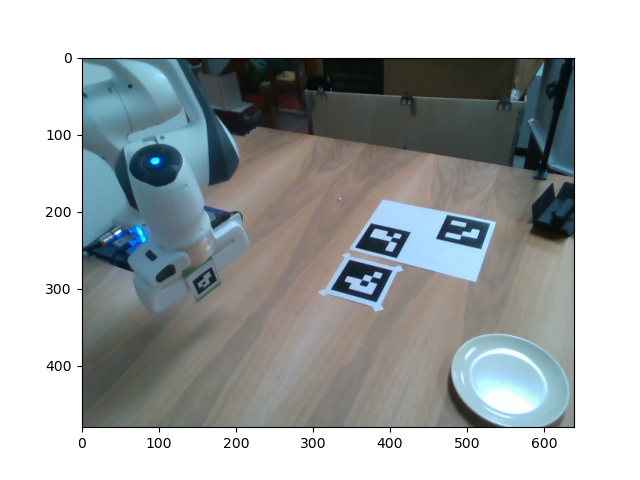

In [21]:
%matplotlib widget
with open('caldata_hands_down.pkl', 'rb') as f:
    data=pickle.load(f)

print('pos_ee_base', data[0]['pos'])
print('ori_ee_base', data[0]['ori'])
print('intrinsics[0]', data[0]['intrinsics'][0])
plt.imshow(data[0]['imgs'][0][:,:,::-1])

## Corner Detection

In [22]:
data=detect_corners(data)

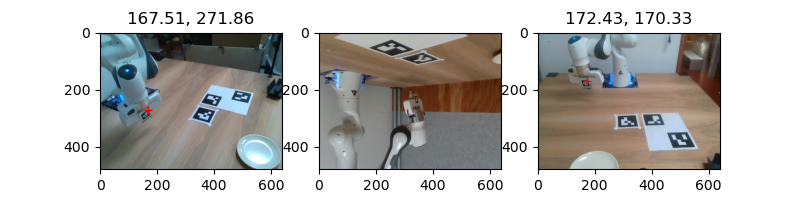

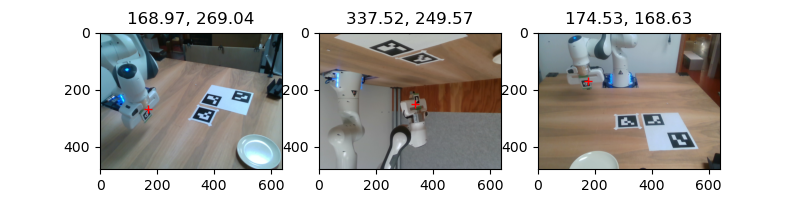

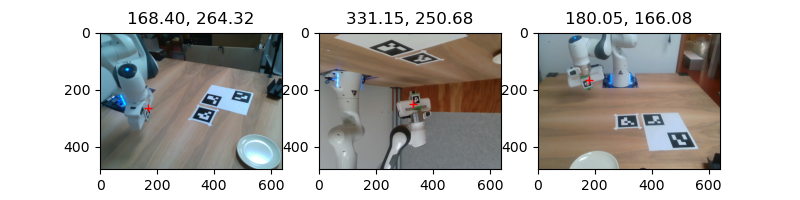

In [23]:
for i,d in enumerate(data[:3]):
    plt.figure(figsize=(8, 2))
    for j, img in enumerate(d['imgs']):
        plt.subplot(1,3,j+1)
        plt.imshow(img[:,:,::-1])
        if d['corners'][j] is not None:
            x,y = d['corners'][j]
            plt.plot(x,y, 'r+')
            plt.title(f'{x:.2f}, {y:.2f}')

In [8]:
# helper function
def extract_obs_data_std(data, camera_index):
    obs_data_std = []
    for d in data:
        if d['corners'][camera_index] is not None:
            obs_data_std.append((
                torch.tensor(d['corners'][camera_index], dtype=torch.float64),
                d['pos'].double(),
                quat2rotvec(d['ori'].double())
            ))

    ic = data[0]['intrinsics'][camera_index]
    K=build_proj_matrix(
        fx=ic['fx'],
        fy=ic['fy'],
        ppx=ic['ppx'],
        ppy=ic['ppy'])
    return obs_data_std, K
    

## Find optimal parameter for each camera

In [9]:
num_of_camera=3
params=[]
for i in range(num_of_camera):
    print(f'Solve camera {i} pose')
    obs_data_std, K = extract_obs_data_std(data, i)
    print('number of images with keypoint', len(obs_data_std))
    param=torch.zeros(9, dtype=torch.float64, requires_grad=True)
    L = lambda param: mean_loss(obs_data_std, param, K)
    param_star=find_parameter(param, obs_data_std, K)

    print('found param loss (mean pixel err)', L(param_star).item())
    params.append(param_star)

Solve camera 0 pose
number of images with keypoint 57
found param loss (mean pixel err) 0.5787683537142804
Solve camera 1 pose
number of images with keypoint 72
found param loss (mean pixel err) 0.48573467593671915
Solve camera 2 pose
number of images with keypoint 81
found param loss (mean pixel err) 0.5358834387791274


In [10]:
with torch.no_grad():
    print(torch.stack(params))

tensor([[-2.2093e+00, -4.8459e-01,  3.2695e-01,  8.0617e-01, -6.0414e-01,  6.8486e-01,  1.7252e-03, -2.5447e-02,
          4.0580e-02],
        [ 1.5498e+00, -5.3020e-01, -5.0158e-01,  8.8358e-01,  5.6237e-01,  2.0085e-01,  1.3255e-03, -2.6299e-02,
          4.2587e-02],
        [-1.6050e+00, -1.5131e+00,  8.6170e-01,  1.2594e+00, -6.2431e-03,  5.5874e-01,  1.4979e-03, -2.7915e-02,
          4.4890e-02]], dtype=torch.float64)


## Visualize Re-projection Error

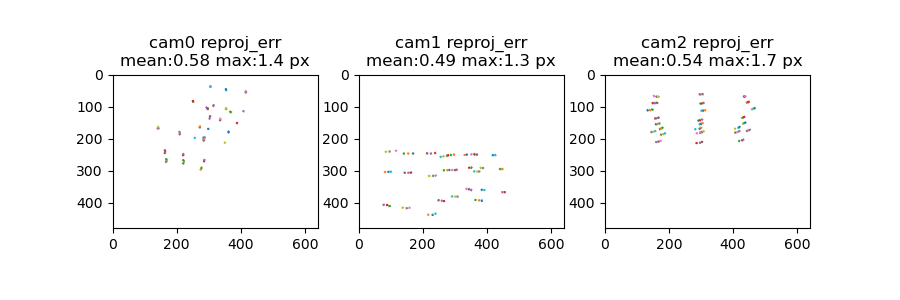

In [16]:
%matplotlib widget
plt.figure(figsize=(9,3))
for camera_index in range(num_of_camera):
    ax=plt.subplot(1,3, camera_index+1)
    obs_data_std, K = extract_obs_data_std(data, camera_index)
    err=[]
    for obs_marker, pos_ee_base, ori_ee_base in obs_data_std:
        with torch.no_grad():
            proj_marker = marker_proj(params[camera_index], pos_ee_base, ori_ee_base, K)
        
        err.append((proj_marker-obs_marker).norm())
        plt.plot((obs_marker[0], proj_marker[0]),
                 (obs_marker[1], proj_marker[1]),
                 '-'
                )
    ax.set(xlim=(0, 640), ylim=(480, 0))
    ax.set_aspect('equal','box')
    errs = torch.stack(err)
    ax.set_title(f'cam{camera_index} reproj_err\nmean:{errs.mean():.2f} max:{errs.max():.2} px')        

## Visualize identified camera pose and marker in robot_base frame

In [12]:

import sophus as sp
from fairotag.scene import SceneViz


In [13]:
def makepose(rotvec, trans):
    return sp.SE3(rotmat(rotvec).detach().numpy(), trans.detach().numpy())

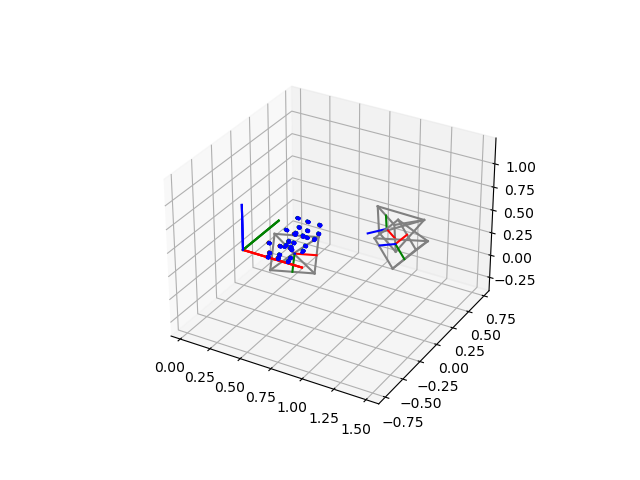

In [15]:
%matplotlib widget
sv = SceneViz()
for i, param in enumerate(params):
    camera_base_ori = param[:3]
    camera_base_pos = param[3:6]
    
    sv.draw_camera(makepose(camera_base_ori, camera_base_pos), .3)
    sv.draw_axes(sp.SE3(), .5)
    
    #plot markers 
    obs_data_std, K = extract_obs_data_std(data, i)
    p_marker_ee = params[i][6:9]
    for d in obs_data_std:        
        p_marker_base = rotmat(d[2]).matmul(p_marker_ee) + d[1]
        pose_marker_base = makepose(torch.zeros(3), p_marker_base)
        sv.draw_marker(pose_marker_base, 0, 0.01, color=['r','g','b'][i])
        
sv.show()